In [7]:
import pandas as pd
from pathlib import Path
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Blast import NCBIWWW, NCBIXML
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import re

from src.sup_data_to_fasta import load_xlsx

sup5_file_path = Path("data/Liu_sup5_data.xlsx")
alignments_files_paths = [
    Path("output/EP-OD0_alignments_results.tsv"),
    Path("output/ESP-OD2_alignments_results.tsv"),
    Path("output/SP-OD2_alignments_results.tsv")
    ]

# Análise Exploratória dos Dados Suplementares 5

## Sobre

Este notebook contém uma análise exploratória dos dados fornecidos por Liu, et al. No [suplemento 5](https://www.nature.com/articles/s41467-023-43632-1#additional-information
) com o objetivo de averiguar os tratamentos executados no artigo

### Objetivo

* Verificar a origem das tags dos pares sRNA/mRNA dos dados suplementares.
* Ganhar mais insight sobre as interações medidas.



In [8]:
def add_scenario_column(df_dict):
    return {k:df.assign(scenario=k) for k,df in df_dict.items()}

def extract_scenario_from_file_path(string_arg):
    return re.search(r"(.*)-(.*)", string_arg).group(1)

def concat_df_dict(df_dict):
    return pd.concat(df_dict.values())

alignments_df_list = [pd.read_csv(file_path, sep='\t') for file_path in alignments_files_paths]
alignments_df_dict = {extract_scenario_from_file_path(k.name):v for k,v in zip(alignments_files_paths, alignments_df_list)}
alignments_df_dict = add_scenario_column(alignments_df_dict)
alignments_df = concat_df_dict(alignments_df_dict)

sup5_data_df_dict = load_xlsx(sup5_file_path)
sup5_data_df_dict = {extract_scenario_from_file_path(k):v for k,v in sup5_data_df_dict.items()}
sup5_data_df_dict = add_scenario_column(sup5_data_df_dict)
sup5_data_df = concat_df_dict(sup5_data_df_dict)

## Saída do BLAST

Os dados de alinhamento foram obtidos executando-se um blast conforme descrito no fluxograma. Informações sobre as colunas de saída podem ser encontradas em https://www.metagenomics.wiki/tools/blast/blastn-output-format-6.

In [9]:
def should_be_only_one_genome(df):
    return df.sseqid.nunique() == 1

def query_start_should_always_be_less_than_query_end(df):
    return (df.qstart <= df.qend).all()

# validationg
assert should_be_only_one_genome(alignments_df), "o banco de dados deveria ter apenas um genoma de referência de Salmonella" # all alignments are done to same Salmonella enterica genome
assert query_start_should_always_be_less_than_query_end(alignments_df), "O ínicio da query deve ser menor ou igual ao fim da query"

In [24]:
def not_aligned(col):
    return col[~col.isin(alignments_df.qseqid)]

query_was_not_RNA1 = not_aligned(sup5_data_df["RNA1 name"])
query_was_not_RNA2 = not_aligned(sup5_data_df["RNA2 name"])

filtered_alignments_df = alignments_df[alignments_df['qseqid'].isin(query_was_not_RNA1) & alignments_df['qseqid'].isin(query_was_not_RNA2)]
print(f"# queries ids criados: {len(filtered_alignments_df)}")

not_aligned_RNA1 = sup5_data_df[~sup5_data_df["RNA1 name"].isin(alignments_df.qseqid)]
not_aligned_RNA2 = sup5_data_df[~sup5_data_df["RNA2 name"].isin(alignments_df.qseqid)]

filtered_sup5_data_df = sup5_data_df[sup5_data_df["RNA1 name"].isin(not_aligned_RNA1["RNA1 name"]) | sup5_data_df["RNA2 name"].isin(not_aligned_RNA2["RNA2 name"])]
print(f"# queries não alinhadas {len(filtered_sup5_data_df)}")

# queries ids criados: 0
# queries não alinhadas 158


<Figure size 1000x1000 with 0 Axes>

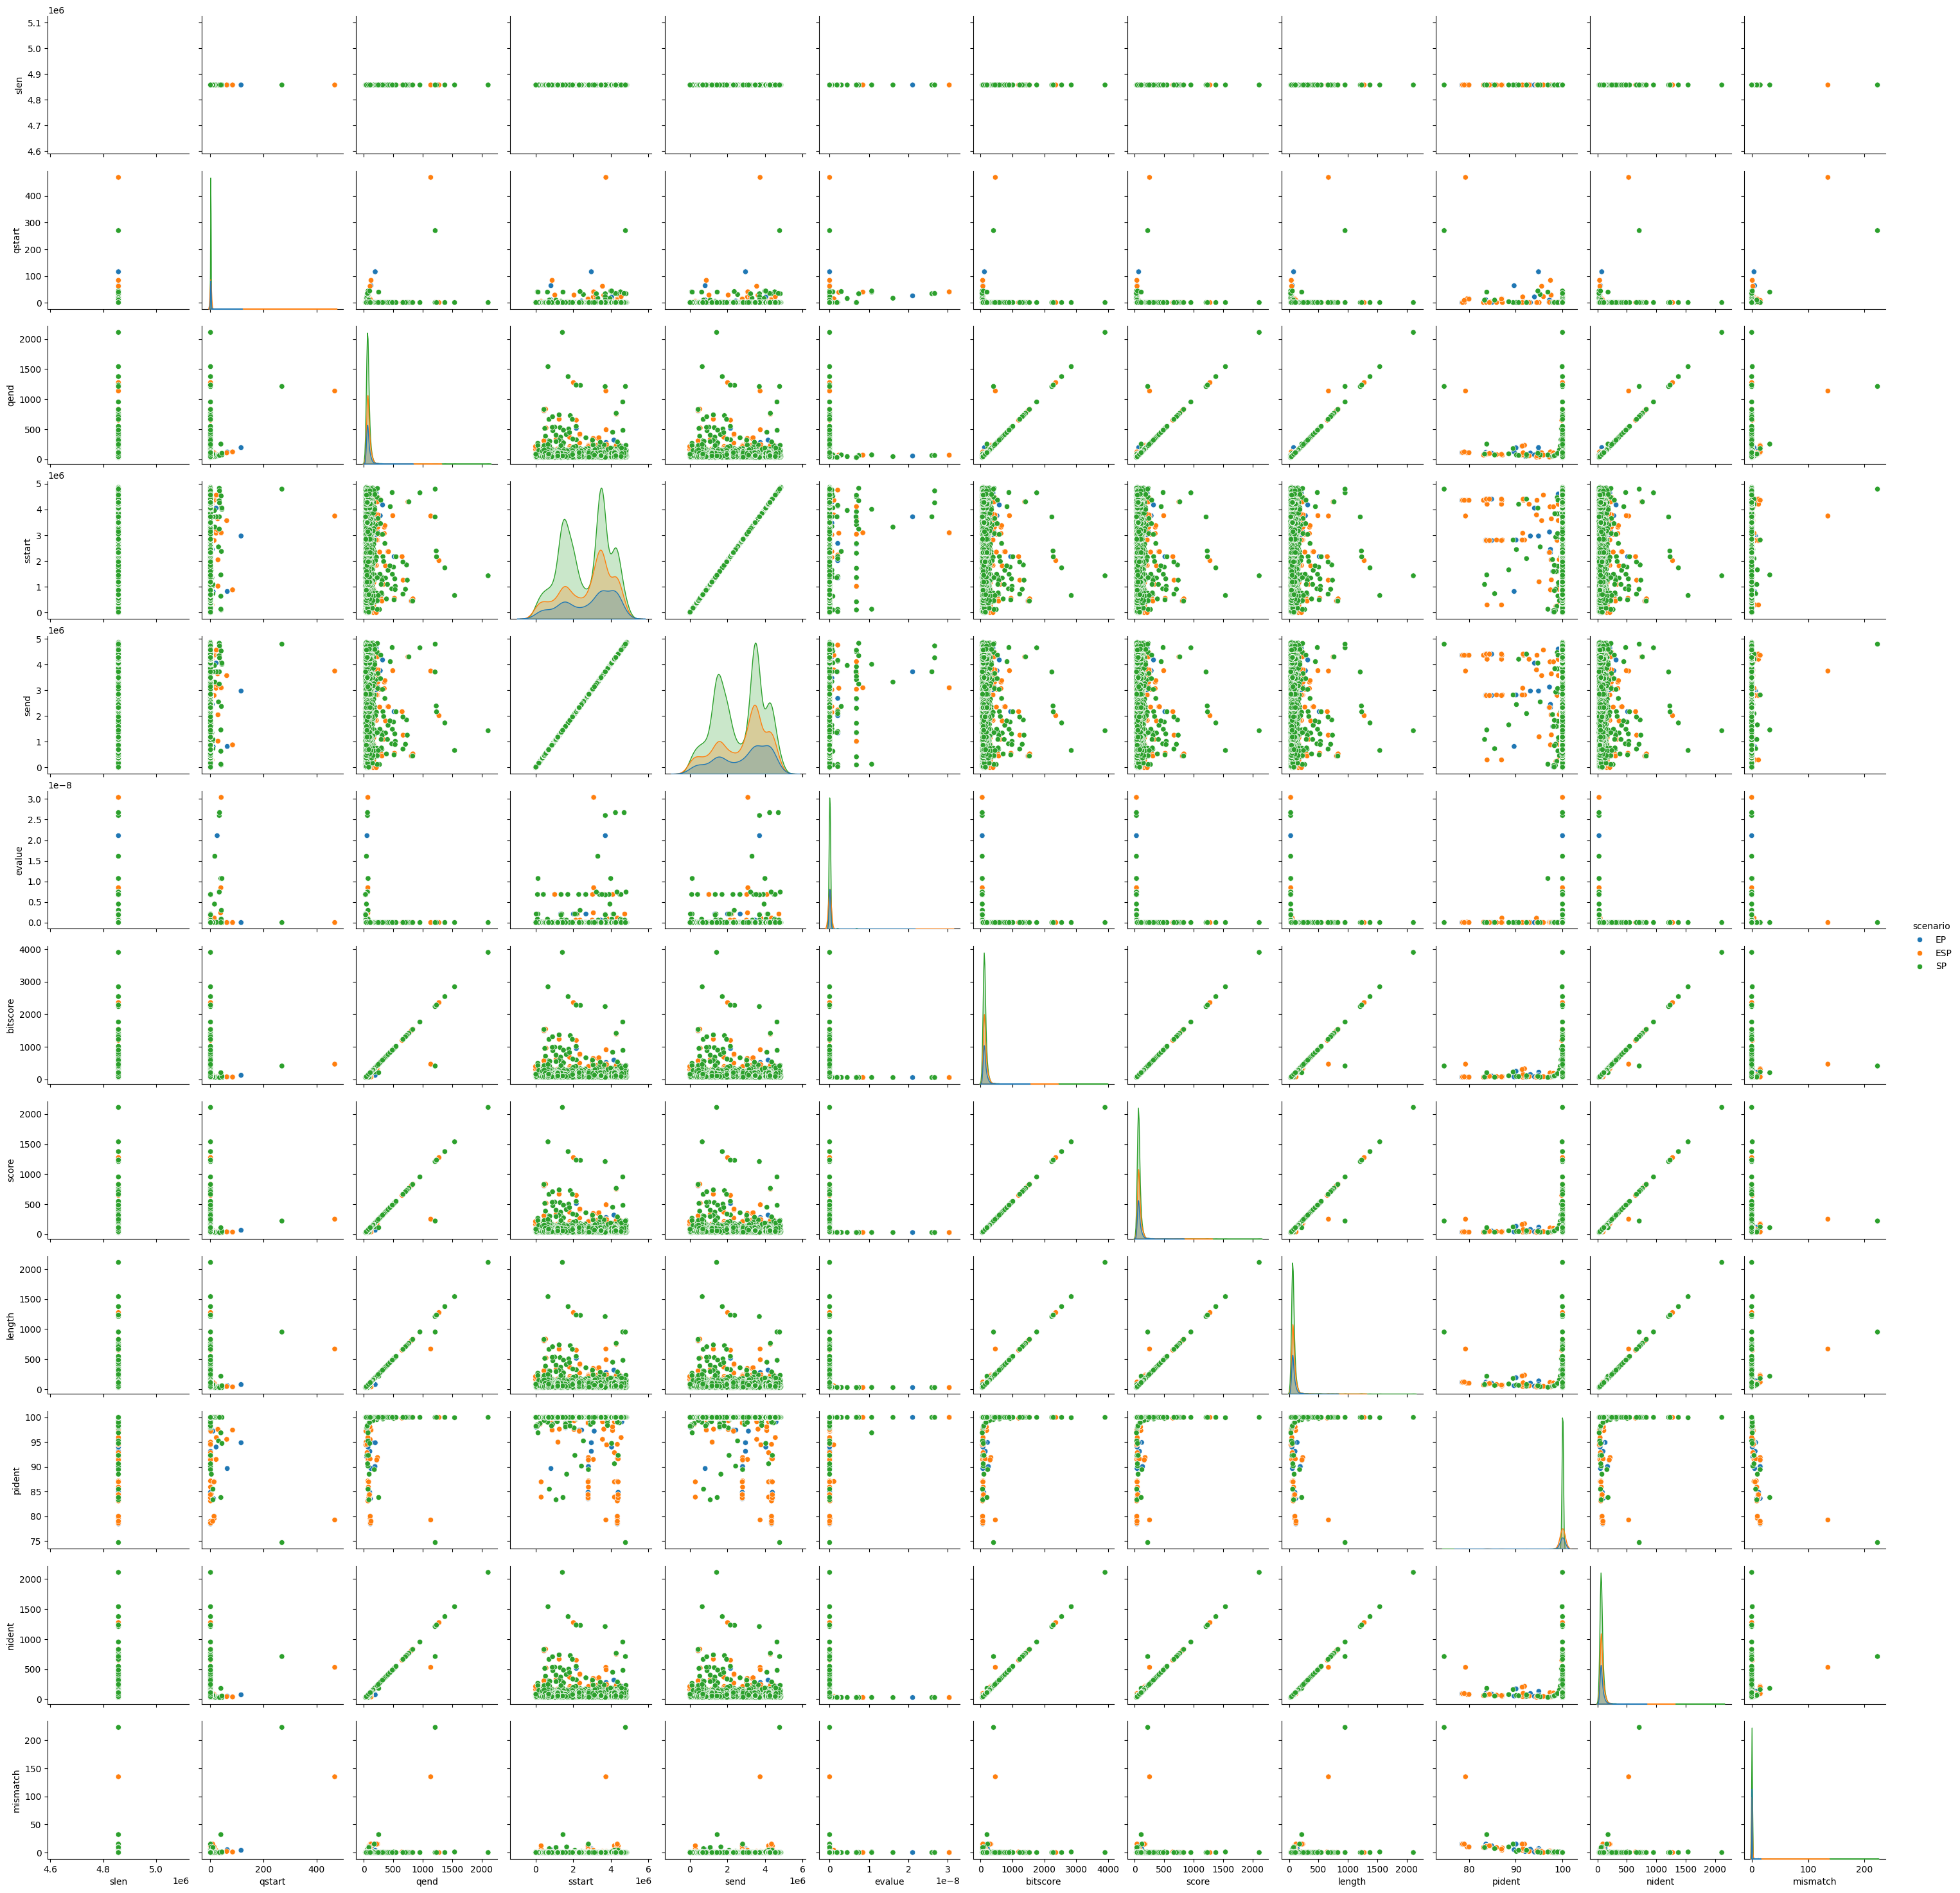

In [11]:
plt.figure(figsize=(10,10)) 
sns.pairplot(alignments_df.get(['scenario', 'slen', 'qstart', 'qend',
                                'sstart', 'send', 'qseq', 'sseq', 'evalue', 'bitscore', 'score',
                                'length', 'pident', 'nident', 'mismatch']), hue='scenario')